# Импорт

In [29]:
import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline
from datetime import datetime, timedelta

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures

pd.set_option('max_colwidth', 120)
pd.set_option('display.width', 500)
pd.set_option('display.max_rows', 40)
pd.set_option('display.max_columns', 50)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


In [30]:
RANDOM_SEED = 42

In [31]:
!pip freeze > requirements.txt

In [32]:
def creatre_columns_NAN(data, list_columns):
    """На вход подаётся список колонок и ДФ, для которых создаются новые колонки с нулями и единицами,
    где 1 - в месте пропуска"""
    data_Nan = pd.DataFrame()
    for i in list_columns:
        data_Nan[i+'_is_NAN'] = pd.isna(data[i]).astype('uint8')
    return data_Nan

In [33]:
def IQR_for_column(column):
    """Функция возвращает квартили, выводит границы для выбросов, согласно IQR и 
    считает сколько выбросов (в том числе в %)"""
    perc25 = data[column].quantile(0.25)
    perc75 = data[column].quantile(0.75)
    IQR = perc75 - perc25
    min_out = perc25 - 1.5*IQR
    max_out = perc75 + 1.5*IQR
    anomaly = len(data[data[column] > max_out]) + \
        len(data[data[column] < min_out])
    print(
        '25-й перцентиль: {} |'.format(perc25),
        '75-й перцентиль: {} |'.format(perc75),
        "IQR: {} | ".format(IQR),
        "Границы выбросов: [{}, {}].".format(min_out, max_out))
    print("Выбросов, согласно IQR: {} | {:2.2%}".format(
        anomaly, anomaly/len(data)))

# DATA

In [34]:
df_flights = pd.read_csv('Project_4.csv')

In [35]:
df_flights.head(5)

,flight_id,departure_airport,arrival_airport,ticket_amount,duration,fuel_costs,profit_from_the_flight
0,136119,AAQ,SVO,1653000.0,1.683333,172508.0,1480492.0
1,136120,AAQ,SVO,1605400.0,1.650000,169092.0,1436308.0
2,136122,AAQ,SVO,1431000.0,1.666667,170800.0,1260200.0
3,136130,AAQ,SVO,1556600.0,1.650000,169092.0,1387508.0
4,136131,AAQ,SVO,1812800.0,1.650000,169092.0,1643708.0


In [36]:
df_flights.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127 entries, 0 to 126
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   flight_id               127 non-null    int64  
 1   departure_airport       127 non-null    object 
 2   arrival_airport         127 non-null    object 
 3   ticket_amount           127 non-null    float64
 4   duration                127 non-null    float64
 5   fuel_costs              127 non-null    float64
 6   profit_from_the_flight  127 non-null    float64
dtypes: float64(4), int64(1), object(2)
memory usage: 7.1+ KB


In [37]:
df_flights['sample'] = 1
data = df_flights.append(df_flights, sort=False).reset_index(drop=True)

In [38]:
data.info()
display(data.sample(3))
print("Размер общего датасета: {}".format(data.shape))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 254 entries, 0 to 253
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   flight_id               254 non-null    int64  
 1   departure_airport       254 non-null    object 
 2   arrival_airport         254 non-null    object 
 3   ticket_amount           254 non-null    float64
 4   duration                254 non-null    float64
 5   fuel_costs              254 non-null    float64
 6   profit_from_the_flight  254 non-null    float64
 7   sample                  254 non-null    int64  
dtypes: float64(4), int64(2), object(2)
memory usage: 16.0+ KB


,flight_id,departure_airport,arrival_airport,ticket_amount,duration,fuel_costs,profit_from_the_flight,sample
183,136479,AAQ,SVO,1738400.0,1.650000,169092.0,1569308.0,1
47,136428,AAQ,SVO,1678600.0,1.650000,169092.0,1509508.0,1
44,136411,AAQ,SVO,1590800.0,1.666667,170800.0,1420000.0,1


Размер общего датасета: (254, 8)


Подробнее по признакам:
* Flight_id: Номер рейса
* departure_airport: Аэропорт вылета
* arrival_airport: Аэропорт прилёта
* ticket_amount: Выручка от продажи билетов
* duration: Продолжительность полёта
* fuel_costs: Стоимость топлива
* profit from the flight: Условная выручка рейса

In [39]:
data.sample(5)

,flight_id,departure_airport,arrival_airport,ticket_amount,duration,fuel_costs,profit_from_the_flight,sample
92,136754,AAQ,EGO,721200.0,0.816667,59281.833333,6.619182e+05,1
20,136249,AAQ,SVO,1800600.0,1.633333,167384.000000,1.633216e+06,1
29,136284,AAQ,SVO,1677400.0,1.683333,172508.000000,1.504892e+06,1
13,136181,AAQ,SVO,1689600.0,1.650000,169092.000000,1.520508e+06,1
40,136383,AAQ,SVO,1493200.0,1.700000,174216.000000,1.318984e+06,1


# Cleaning and Prepping Data
Обычно данные содержат в себе кучу мусора, который необходимо почистить, для того чтобы привести их в приемлемый формат. Чистка данных — это необходимый этап решения почти любой реальной задачи.   


## 1. Обработка NAN 
У наличия пропусков могут быть разные причины, но пропуски нужно либо заполнить, либо исключить из набора полностью. Но с пропусками нужно быть внимательным, **даже отсутствие информации может быть важным признаком!**   
По этому перед обработкой NAN лучше вынести информацию о наличии пропуска как отдельный признак 

Дубликатов найдено: 254
Пропусков найдено: 0


<AxesSubplot:>

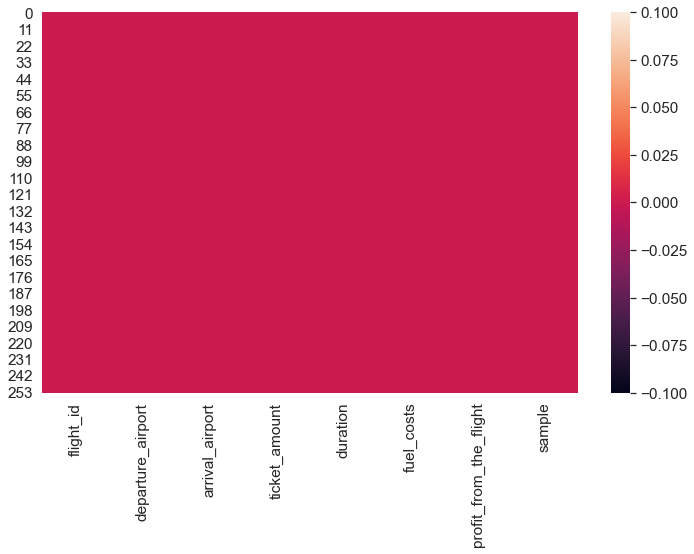

In [40]:
# Проверяем, где есть пропуски и дубликаты
print("Дубликатов найдено:", data.duplicated(keep=False).sum())
print("Пропусков найдено:", data.isnull().sum().sum())

# "Матрица" с пропусками для наглядной оценки
plt.subplots(figsize=(12, 7))
sns.heatmap(data.isnull())

# City

Text(0, 0.5, 'Количество рейсов')

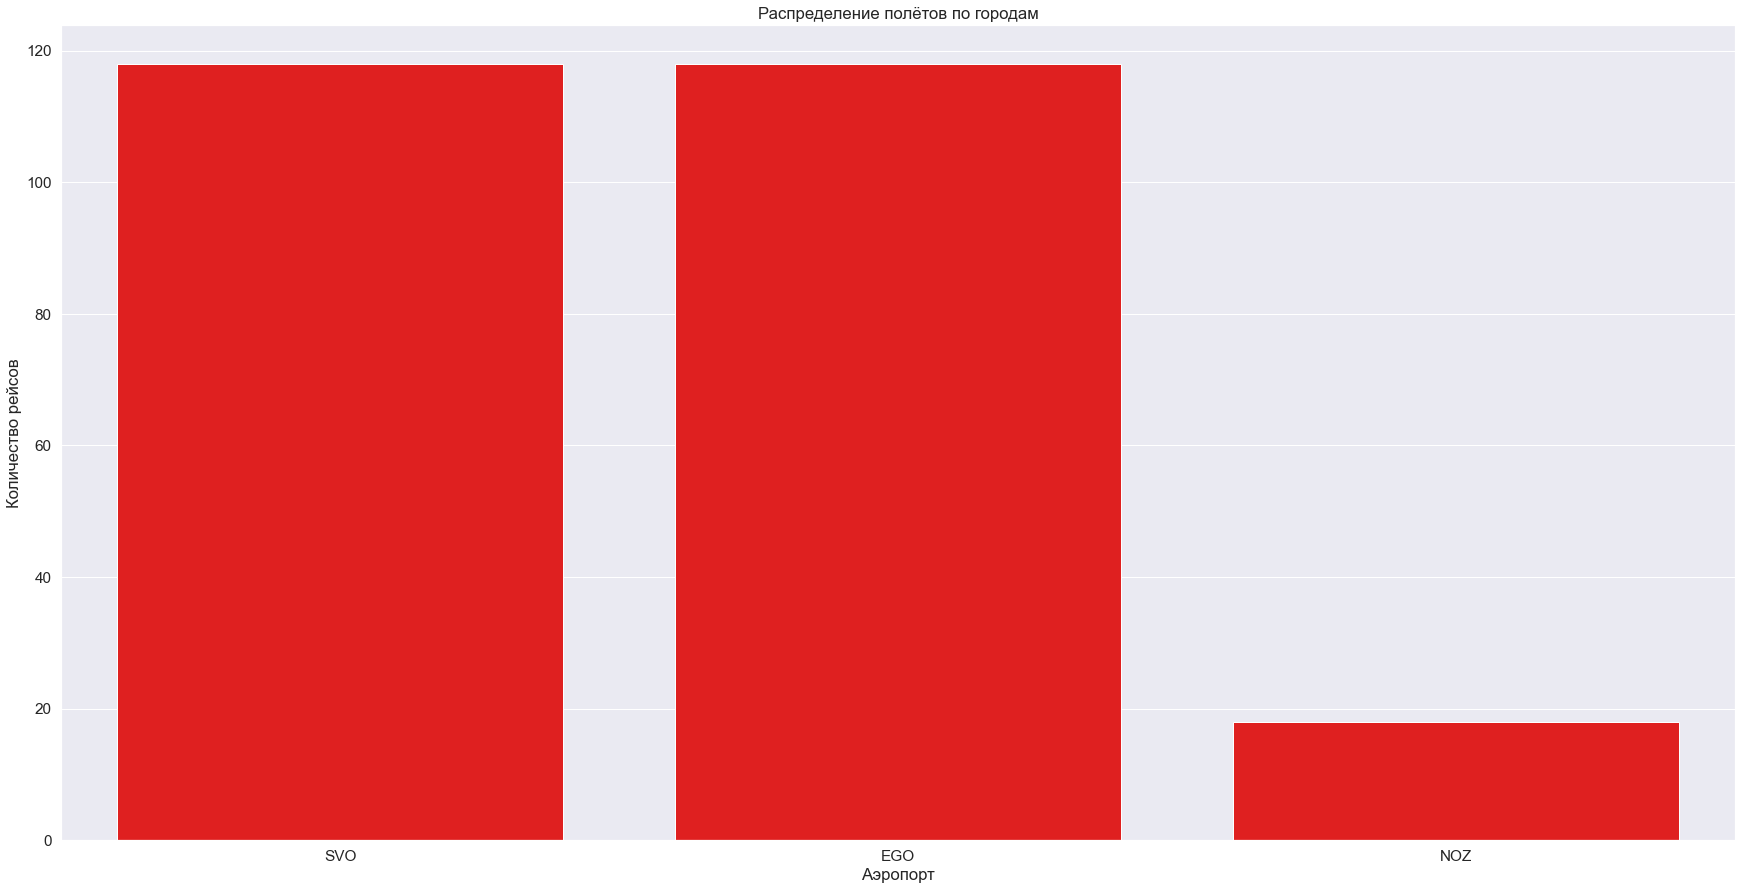

In [41]:
# Посмотрим на распределение полётов по аэропортам
sns.set(font_scale=1.4)
plt.subplots(figsize=(30, 15))
plt.xticks(ticks=range(0, 7500, 500))
plt.title('Распределение полётов по городам')
sns.countplot(x="arrival_airport",
              data=data,
              order=data.arrival_airport.value_counts().index,
              color='red')
plt.xlabel('Аэропорт')
plt.ylabel('Количество рейсов')

# EDA 


### Посмотрим распределение выручки от полётов

Text(0, 0.5, 'Размер выручки')

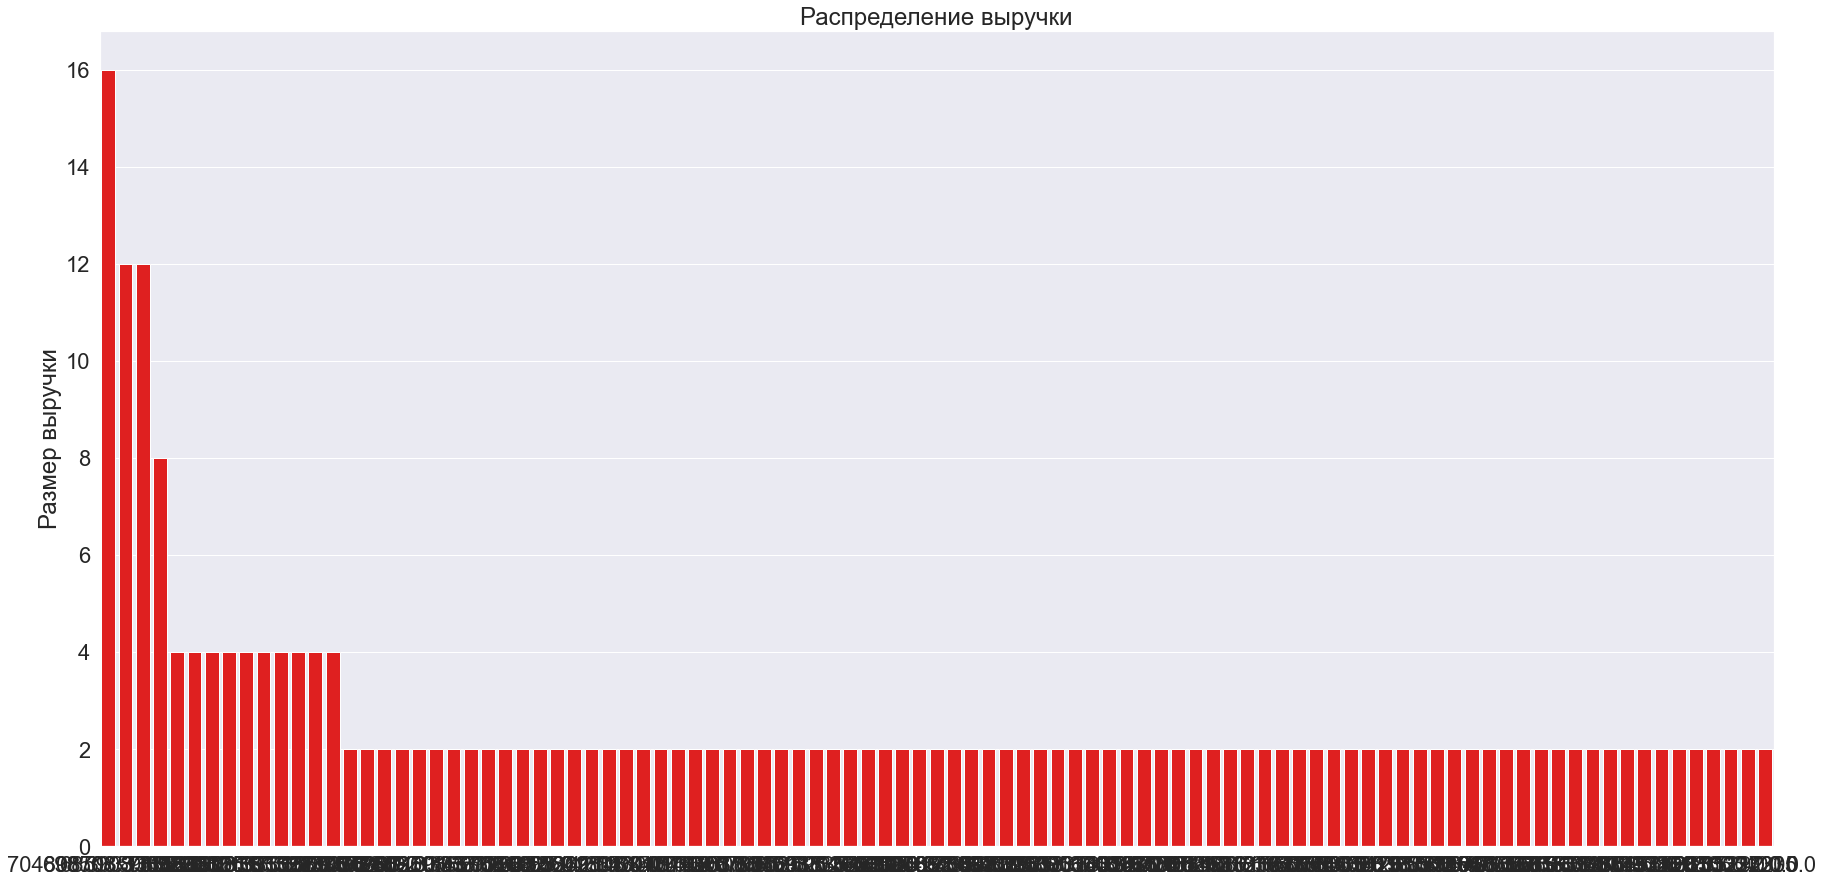

In [43]:
sns.set(font_scale=2)
plt.subplots(figsize=(30, 15))
plt.xticks(ticks=range(0, 1111, 500))
plt.title('Распределение выручки')
sns.countplot(x="profit_from_the_flight",
              data=data,
              order=data.profit_from_the_flight.value_counts().index,
              color='red')
plt.xlabel('')
plt.ylabel('Размер выручки')

Как видно на графике, все рейсы являются выгодными.